In [1]:
import pandas as pd
from textblob import TextBlob
from nltk.corpus import stopwords
from textblob import Word
import multiprocessing
import pickle
from nltk import download
from gensim.models import Word2Vec
import gensim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from display_confusion_matrix import display_confusion_matrix

# First look at the data

In [15]:
quora = pd.read_csv('train.csv')

In [23]:
quora.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [17]:
quora.shape

(404290, 6)

In [5]:
len(quora.qid1.unique()), len(quora.qid2.unique())

(290654, 299364)

In [6]:
quora.is_duplicate.mean() 
# 37% of the data is label 1, I can treat this as a balanced dataset

0.369197853026293

In [21]:
# not duplicated
quora.question1[2], quora.question2[2]

('How can I increase the speed of my internet connection while using a VPN?',
 'How can Internet speed be increased by hacking through DNS?')

In [22]:
# duplicated
quora.question1[7], quora.question2[7]

('How can I be a good geologist?', 'What should I do to be a great geologist?')

## Preprocessing

In [9]:
download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
download('punkt') 

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
def clean_question(q):
    """
    Clean the text in a given question to provide
    a list of relevent words
    """
    q = str(q)
    q = q.lower() # lowercase
    q = TextBlob(q).tokens #tokenize
    new_q = []
    for w in q:
        if not w.isalpha(): #remove words with numbers
            continue
        else:
            if w not in stop_words: #remove stop words
                new_q.append(w)
    return new_q

In [12]:
%%time
# remove stop words
quora.question1 = quora.question1.apply(clean_question)
quora.question2 = quora.question2.apply(clean_question)

CPU times: user 2min 50s, sys: 772 ms, total: 2min 50s
Wall time: 2min 50s


In [13]:
quora.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0
1,1,3,4,"[story, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",0
2,2,5,6,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0
3,3,7,8,"[mentally, lonely, solve]","[find, remainder, math, divided]",0
4,4,9,10,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0


# Use pretrained vectors from google

In [14]:
%%time
google_vectors = gensim.models.KeyedVectors.\
            load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

CPU times: user 2min, sys: 2.9 s, total: 2min 3s
Wall time: 2min 3s


In [15]:
%%time
# normalize vectors
google_vectors.init_sims(replace=True)

CPU times: user 28.2 s, sys: 0 ns, total: 28.2 s
Wall time: 28.2 s


# Calculate Word Movers Distance (WMD)

In [16]:
# sample calculation for a duplicate question pair
google_vectors.wmdistance(quora.question1[0], quora.question2[0])

0.1980421792359047

In [17]:
# sample calculation for not duplicated question pair
google_vectors.wmdistance(quora.question1[1], quora.question2[1])

1.1469968485379658

In [18]:
# calculate wmd for all question pairs
%%time
quora['wmd']= quora.apply(lambda x: google_vectors.wmdistance(x['question1'], x['question2']),
                  axis=1)

CPU times: user 5min 1s, sys: 104 ms, total: 5min 1s
Wall time: 5min 1s


In [19]:
quora.head()

,id,qid1,qid2,question1,question2,is_duplicate,wmd
0,0,1,2,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0,0.198042
1,1,3,4,"[story, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",0,1.146997
2,2,5,6,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0,0.694896
3,3,7,8,"[mentally, lonely, solve]","[find, remainder, math, divided]",0,1.256356
4,4,9,10,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0,0.972994


In [20]:
quora[quora.is_duplicate==0].wmd.min(), quora[quora.is_duplicate==0].wmd.max()
# inf is maximum wmd distance

(0.0, inf)

In [21]:
quora[quora.is_duplicate==1].wmd.min(), quora[quora.is_duplicate==1].wmd.max()
# inf is maximum wmd distance

(0.0, inf)

In [22]:
quora[quora.wmd == 0].head()
# 0.0 resulted when cleaned words are the same

,id,qid1,qid2,question1,question2,is_duplicate,wmd
8,8,17,18,"[use, シ, instead, し]","[use, instead]",0,0.0
12,12,25,26,"[make, physics, easy, learn]","[make, physics, easy, learn]",1,0.0
41,41,83,84,"[expect, cognizant, confirmation, mail]","[expect, cognizant, confirmation, mail]",0,0.0
42,42,85,86,"[make, month, day, trading]","[make, month, day, trading]",0,0.0
49,49,99,100,"[make, friends]","[make, friends]",1,0.0


In [23]:
quora[quora.wmd == np.inf].head()
# inf when cleaned questions have no words or when words are not available in google vectors

,id,qid1,qid2,question1,question2,is_duplicate,wmd
221,221,443,444,"[puk, code]",[puk],1,inf
292,292,584,585,[],[],0,inf
613,613,1224,1225,"[arnab, goswami]","[quorans, supportive, modi]",0,inf
848,848,1691,1692,[ielts],"[ielts, use]",1,inf
918,918,1831,1832,[],[],1,inf


In [24]:
# quick inspection of inf cases
quora_temp = pd.read_csv('train.csv')

In [25]:
quora_temp[quora_temp.id==242375].question1, quora_temp[quora_temp.id==242375].question2

(242375    What is Maggi?
 Name: question1, dtype: object, 242375    What is Maggie?
 Name: question2, dtype: object)

In [26]:
quora_temp[quora_temp.id==327177].question1, quora_temp[quora_temp.id==327177].question2

(327177    What is copyscrn.com?
 Name: question1, dtype: object, 327177    What is Kaufmich.com?
 Name: question2, dtype: object)

In [27]:
del quora_temp

In [28]:
# propotion of wmd's having infinity
quora[quora.wmd == np.inf].is_duplicate.mean()

0.1447887323943662

In [29]:
# more likely that infinity values are due to non duplicated questions
# setting inifinity values to zero
quora.loc[quora.wmd == np.inf, 'wmd'] = 0

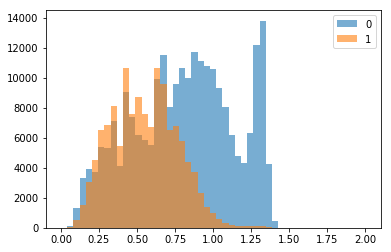

In [6]:
# histogram of wmd
bins = np.linspace(0, 2, 50)
plt.hist(quora[(quora.is_duplicate==0) & (quora.wmd>0)].wmd, bins, alpha=0.6, label='0')
plt.hist(quora[(quora.is_duplicate==1) & (quora.wmd>0)].wmd, bins, alpha=0.6, label='1')
plt.legend(loc='upper right')
plt.show()

In [31]:
with open('quora_with_wmd', 'wb') as f:
    pickle.dump(quora, f)

# Training and validation sets

In [2]:
with open('quora_with_wmd', 'rb') as f:
    quora = pickle.load(f)

In [3]:
# 20% as validation set
X_train, X_val, y_train, y_val = train_test_split(quora.drop('is_duplicate', axis=1)
                                                  , quora.is_duplicate.copy(), 
                                                  test_size=0.1, random_state=8)

In [4]:
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

# Modeling 

## Decision tree

In [5]:
# use a decision tree
losses = []
for md in [4,5,6,7]:
    for msl in [2,3,4,5]:
        clf = tree.DecisionTreeClassifier(min_samples_leaf=msl, max_depth=md)
        clf = clf.fit(X_train[['wmd']], y_train)
        preds = clf.predict_proba(X_val[['wmd']])
        loss = log_loss(y_val, preds)
        losses.append((md, msl, loss))

In [6]:
# best hyper parameter combination for the decision tree
sorted(losses, key=lambda x: x[2])

[(5, 2, 0.5445404469342231),
 (5, 3, 0.544553183347706),
 (5, 4, 0.544553183347706),
 (5, 5, 0.544553183347706),
 (4, 2, 0.5448936261150817),
 (4, 3, 0.5448936261150817),
 (4, 4, 0.5448936261150817),
 (4, 5, 0.5448936261150817),
 (6, 2, 0.5449842173543724),
 (6, 4, 0.5450142526234745),
 (6, 5, 0.5450142526234745),
 (6, 3, 0.5450368991363375),
 (7, 2, 0.5455085462651599),
 (7, 5, 0.5464000669100922),
 (7, 3, 0.5464013168994744),
 (7, 4, 0.5464155472899086)]

In [7]:
# being conservative
# maxdepth = 5, minsampleleaf=2 

In [8]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=2, max_depth=5)
clf = clf.fit(X_train[['wmd']], y_train)
preds_t = clf.predict_proba(X_train[['wmd']])
preds_v = clf.predict_proba(X_val[['wmd']])
log_loss(y_train, preds_t), log_loss(y_val, preds_v)

(0.5455237913821421, 0.5445404469342231)

In [9]:
# baseline perfromance when always predicted as not duplicated
1 - y_val.mean()

0.6306364243488585

In [10]:
# accuracy
((preds_v[:,1] > 0.5) == y_val).mean()

0.676865616265552

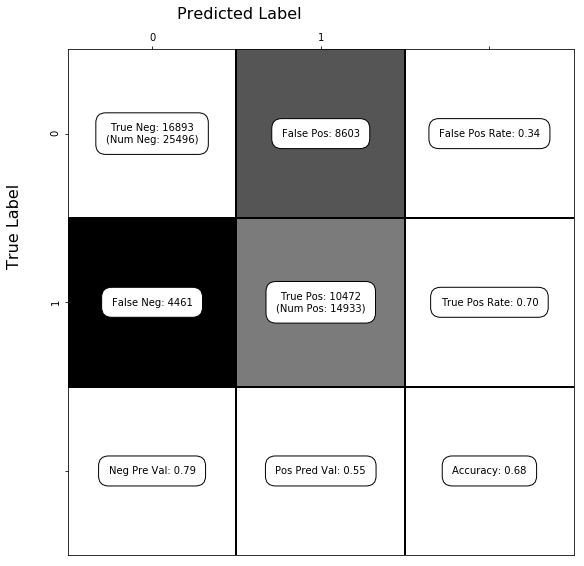

In [12]:
display_confusion_matrix(confusion_matrix(y_val, preds_v[:,1] > 0.5))

# Create my own embeddings

In [62]:
quora_tunning = pd.read_csv("train.csv")

In [63]:
quora_tunning.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [64]:
def clean_question_tunning(q):
    """
    Clean the text in a given question to provide
    a list of relevent words
    """
    q = str(q)
    q = q.lower() # lowercase
    q = TextBlob(q).tokens #tokenize
    new_q = []
    for w in q:
        if not w.isalpha(): #remove words with numbers
            continue
        else:
            new_q.append(w)
    return new_q

In [65]:
%%time
# remove stop words
quora_tunning.question1 = quora_tunning.question1.apply(clean_question_tunning)
quora_tunning.question2 = quora_tunning.question2.apply(clean_question_tunning)

CPU times: user 2min 35s, sys: 776 ms, total: 2min 36s
Wall time: 2min 36s


In [66]:
quora_tunning.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...",0
1,1,3,4,"[what, is, the, story, of, kohinoor, diamond]","[what, would, happen, if, the, indian, governm...",0
2,2,5,6,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...",0
3,3,7,8,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, is, divided...",0
4,4,9,10,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]",0


In [67]:
# collect all questions
quora_tunning_sentences = list(quora_tunning.question1)+list(quora_tunning.question2)

In [68]:
quora_tunning_sentences[0]

['what',
 'is',
 'the',
 'step',
 'by',
 'step',
 'guide',
 'to',
 'invest',
 'in',
 'share',
 'market',
 'in',
 'india']

In [69]:
del quora_tunning

In [70]:
# train embeddings using question corpus
%%time
# Set values for various parameters
num_features = 300    # Word vector dimensionality
min_word_count = 4   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
print("Training Word2Vec model...")
new_model = Word2Vec(quora_tunning_sentences, workers=num_workers,
                 size=num_features, min_count = min_word_count,
                 window = context, sample = downsampling, seed=1)

Training Word2Vec model...
CPU times: user 2min 51s, sys: 348 ms, total: 2min 51s
Wall time: 49.6 s


In [71]:
new_model.save('own_embeddings')

In [72]:
with open('quora_with_wmd', 'rb') as f:
    quora_own = pickle.load(f)

In [73]:
quora_own.head()

,id,qid1,qid2,question1,question2,is_duplicate,wmd
0,0,1,2,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0,0.198042
1,1,3,4,"[story, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",0,1.146997
2,2,5,6,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0,0.694896
3,3,7,8,"[mentally, lonely, solve]","[find, remainder, math, divided]",0,1.256356
4,4,9,10,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0,0.972994


## WMD usign own embeddings

In [74]:
# calculate wmd using new embeddings
%%time
quora_own['wmd_own']= quora_own.apply(lambda x: new_model.wmdistance(x['question1'], 
                                                                          x['question2']),
                                      axis=1)

/home/ec2-user/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  


CPU times: user 5min 25s, sys: 20 ms, total: 5min 25s
Wall time: 5min 25s


In [75]:
# more likely that infinity values are due to non duplicated questions
# setting inifinity values to zero
quora_own.loc[quora_own.wmd_own == np.inf, 'wmd_own'] = 0

In [78]:
quora_own.shape

(404290, 8)

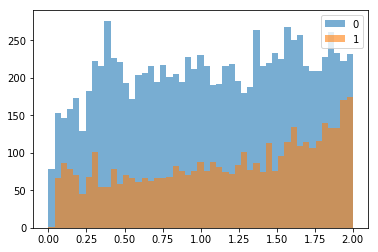

In [79]:
# histogram for wmd calculated using new embeddings
bins = np.linspace(0, 2, 50)
plt.hist(quora_own[(quora_own.is_duplicate==0) & (quora_own.wmd_own>0)].wmd_own, bins, alpha=0.6, label='0')
plt.hist(quora_own[(quora_own.is_duplicate==1) & (quora_own.wmd_own>0)].wmd_own, bins, alpha=0.6, label='1')
plt.legend(loc='upper right')
plt.show()

In [80]:
with open('quora_with_wmd_own', 'wb') as f:
    pickle.dump(quora_own, f)

No difference in distributions, unlikely to make any good predictions